In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import joblib as jb

os.chdir('..')
import AstroPack as AP
os.chdir('./final_models')

from matplotlib import rc
rc('text', usetex=True)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import (mean_absolute_error, median_absolute_error, 
                             r2_score, max_error, mean_squared_error)

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

%matplotlib inline

# Getting the data

### Hyperparameter tuning
First, we import all the hyperparameter tuning results:

In [2]:
os.chdir('../hyperparameter_tuning/teff')
teff_models = pd.read_csv('rf_teff_tuning.csv')

os.chdir('../logg')
logg_models = pd.read_csv('rf_logg_tuning.csv')

os.chdir('../feh')
feh_models = pd.read_csv('rf_FeH_tuning.csv')

os.chdir('../../final_models')

### Stars data (JPLUS + WISE + LAMOST)
Then, we import and treat the data that will be used to train and test the best models:

In [3]:
# Create a list of the columns that will be used
column_list = ['TILE_ID', 'NUMBER', 'combined_teff', 'combined_logg', 'combined_feh'] + AP.Filters['JPLUS'] + AP.Filters['WISE']

# Import the full dataframe with stars that have both JPLUS, WISE and LAMOST data
os.chdir('../data')
stars_raw = pd.read_csv('STEPEs Input Data.csv')
os.chdir('../final_models')

# Drop any row with missing values from the dataframe
stars_raw = stars_raw.dropna()

# Convert it into a dataframe with magnitudes and colors, indexed by the TILE ID and NUMBER of the star
stars_raw, stars = AP.AssembleWorkingDF(stars_raw, addGAIA = False, addWISE=True, addGALEX=False, Colors=True, Combinations=False)
stellar_parameters = stars_raw[['combined_teff', 'combined_logg', 'combined_feh']]

# Split the data into a training (previously the development set) and a test set
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Teff predictor

### Model ranking
Here, we check the 5 best hyperparameter combinations based on the R2 score:

In [4]:
teff_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
28,45,0.25,100,1,0.968766,0.001124
53,136,0.1,100,1,0.968657,0.001050
36,60,0.25,100,1,0.968652,0.001141
37,60,0.5,100,1,0.968641,0.000941
54,136,0.25,100,1,0.968641,0.000960


### Model training
We then choose the best hyperparameter combination (n_features = 45, max_features = 0.25, n_trees = 100, msl = 1) and train a model using that

In [8]:
y_train_teff = y_train['combined_teff']

feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 45, 
                      verbose = 0, step = 20)

rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.25)

rf_teff_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

rf_teff_pipeline = rf_teff_pipeline.fit(x_train, y_train_teff.values.reshape(len(y_train_teff)))
jb.dump(rf_teff_pipeline, open('rf_teff_predictor.sav', 'wb'), compress = 9)

In [5]:
y_test_teff = y_test['combined_teff']

rf_teff_pipeline = jb.load(open('rf_teff_predictor.sav', 'rb'))

teff_predictions = rf_teff_pipeline.predict(x_test)

MAE = mean_absolute_error(y_test_teff, teff_predictions)
RMSE = np.sqrt(mean_squared_error(y_test_teff, teff_predictions))
MaxE = max_error(y_test_teff, teff_predictions)
R2 = r2_score(y_test_teff, teff_predictions)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 66.083
Root Mean Squared Error: 92.810
Max Error: 2077.188
R2 Score: 0.970


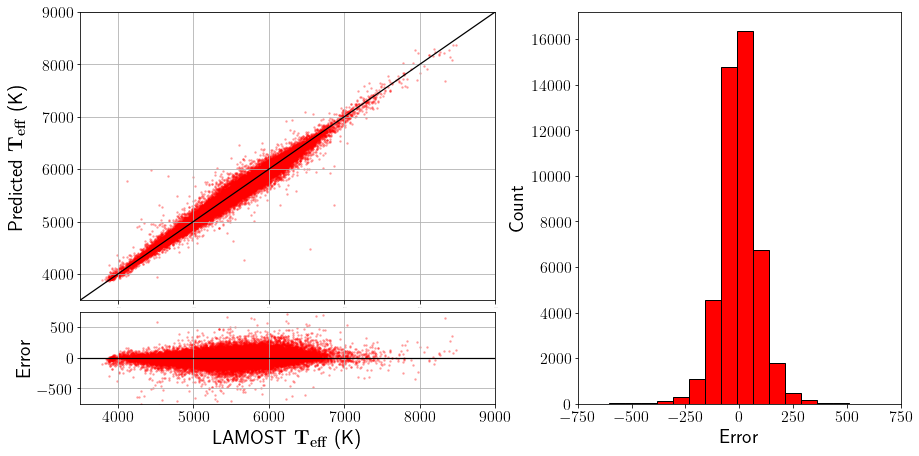

In [7]:
teff_test_results = AP.plot_test_graphs(y_test_teff, teff_predictions, r'$\mathbf{T_{eff}}$ (K)', 
                                        parameter_range = [3500, 9000], error_range = [-750, 750], color = 'red')
teff_test_results.savefig('rf_teff_test_results.jpg', dpi = 250)

# logg predictor

### Model ranking
Here, we check the 5 best hyperparameter combinations based on the R2 score:

In [8]:
logg_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
36,60,0.25,100,1,0.829419,0.003430
15,45,0.25,100,1,0.829220,0.002588
16,45,0.5,100,1,0.828415,0.003847
37,60,0.5,100,1,0.828158,0.004806
57,136,0.25,100,1,0.827530,0.003504


### Model training
We then choose the best hyperparameter combination (n_features = 45, max_features = 0.25, n_trees = 100, msl = 1) and train a model using that

In [13]:
y_train_logg = y_train['combined_logg']

feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 45, 
                      verbose = 0, step = 20)

rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.25)

rf_logg_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

rf_logg_pipeline = rf_logg_pipeline.fit(x_train, y_train_logg.values.reshape(len(y_train_logg)))

jb.dump(rf_logg_pipeline, open('rf_logg_predictor.sav', 'wb'), compress = 9)

In [9]:
y_test_logg = y_test['combined_logg']

rf_logg_pipeline = jb.load(open('rf_logg_predictor.sav', 'rb'))
logg_predictions = rf_logg_pipeline.predict(x_test)

MAE = mean_absolute_error(y_test_logg, logg_predictions)
RMSE = np.sqrt(mean_squared_error(y_test_logg, logg_predictions))
MaxE = max_error(y_test_logg, logg_predictions)
R2 = r2_score(y_test_logg, logg_predictions)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 0.134
Root Mean Squared Error: 0.203
Max Error: 3.856
R2 Score: 0.833


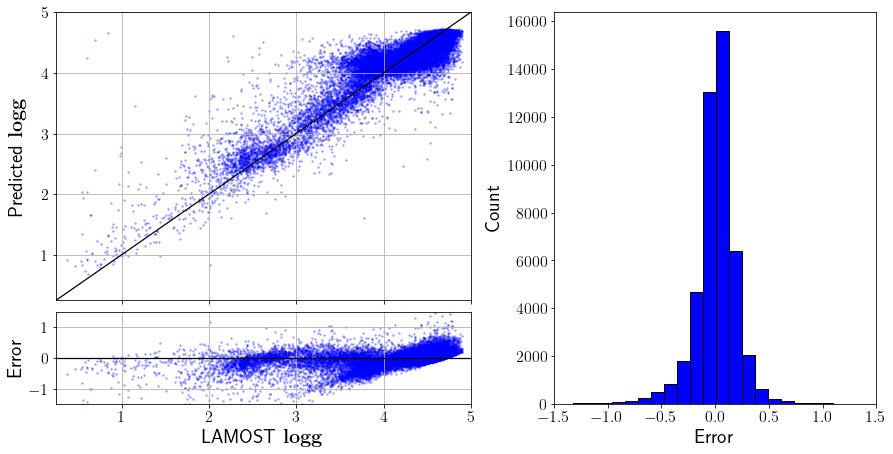

In [12]:
logg_test_results = AP.plot_test_graphs(y_test_logg, logg_predictions, r'$\mathbf{logg}$', 
                                        parameter_range = [0.25, 5.0], error_range = [-1.5, 1.5], color = 'blue')
logg_test_results.savefig('rf_logg_test_results.jpg', dpi = 250)

# FeH predictor

### Model ranking
Here, we check the 5 best hyperparameter combinations based on the R2 score:

In [13]:
feh_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
36,60,0.25,100,1,0.859157,0.002535
26,45,0.25,100,1,0.859072,0.002024
35,60,0.1,100,1,0.858311,0.002934
37,60,0.5,100,1,0.857938,0.002060
27,45,0.5,100,1,0.857924,0.002002


### Model training
We then choose the best hyperparameter combination (n_features = 45, max_features = 0.25, n_trees = 100, msl = 1) and train a model using that

In [6]:
y_train_feh = y_train['combined_feh']

feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 45, 
                      verbose = 0, step = 20)

rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.25)

rf_feh_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

rf_feh_pipeline = rf_feh_pipeline.fit(x_train, y_train_feh.values.reshape(len(y_train_feh)))

jb.dump(rf_feh_pipeline, open('rf_feh_predictor.sav', 'wb'), compress = 9)

In [7]:
y_test_feh = y_test['combined_feh']

rf_feh_pipeline = jb.load(open('rf_feh_predictor.sav', 'rb'))
feh_predictions = rf_feh_pipeline.predict(x_test)

MAE = mean_absolute_error(y_test_feh, feh_predictions)
RMSE = np.sqrt(mean_squared_error(y_test_feh, feh_predictions))
MaxE = max_error(y_test_feh, feh_predictions)
R2 = r2_score(y_test_feh, feh_predictions)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 0.103
Root Mean Squared Error: 0.146
Max Error: 2.210
R2 Score: 0.860


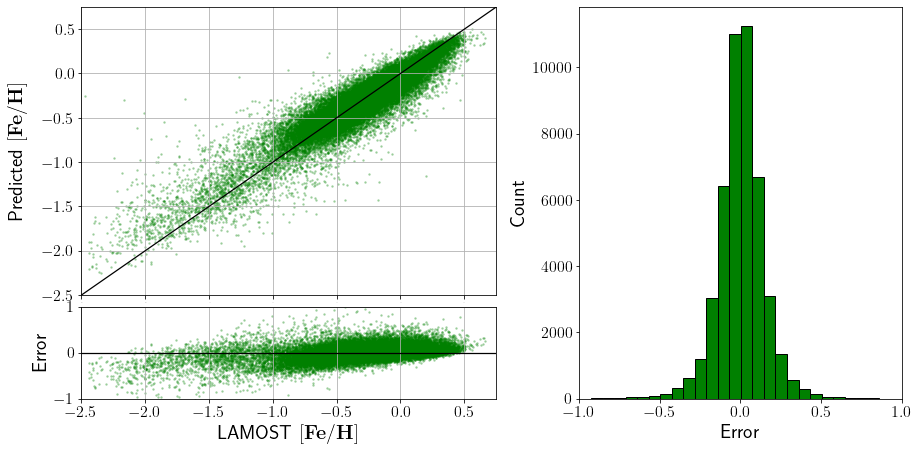

In [8]:
feh_test_results = AP.plot_test_graphs(y_test_feh, feh_predictions, r'$\mathbf{[Fe \slash H]}$', 
                                       parameter_range = [-2.5, 0.75], error_range = [-1.0, 1.0], color = 'green')
feh_test_results.savefig('rf_feh_test_results.jpg', dpi = 250)